# House Prices - Advanced Regression Techniques

## 1. Utilitats

In [1]:
#Importem les llibreries que necesitarem
import os
import zipfile
import joblib

import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
#Funció per baixar les dades automaticament
def download_data(name, path):
    !kaggle competitions download -c $name
    os.makedirs(path, exist_ok=True)
    with zipfile.ZipFile(f"{name}.zip", 'r') as file:
        file.extractall(path)
    file.close()
    os.remove(f"{name}.zip") 
    print("DONE!")

#Funció per carregar les dades
def load_data(file_name, path):
    full_path = os.path.join(path, file_name)
    return pd.read_csv(full_path)

In [3]:
#Baixem les dades de kaggle
name = "house-prices-advanced-regression-techniques"
path = "data"

download_data(name, path) 

#Carreguem a un dataframe les dades
train_set = "train.csv"
submission_set = "test.csv"
train = load_data(train_set, path)
submission = load_data(submission_set, path)


  0%|                                                | 0.00/199k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 199k/199k [00:00<00:00, 2.87MB/s]
DONE!


## 2. Anàlisi de les dades

In [4]:
#Visualitzem les primeres instàncies de la taula
pd.set_option("max_columns", None)
pd.set_option('display.max_rows', 100)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
submission.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
#Numero de valors i categoria
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
#Estadístiques generals
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
#Valors nuls
train.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

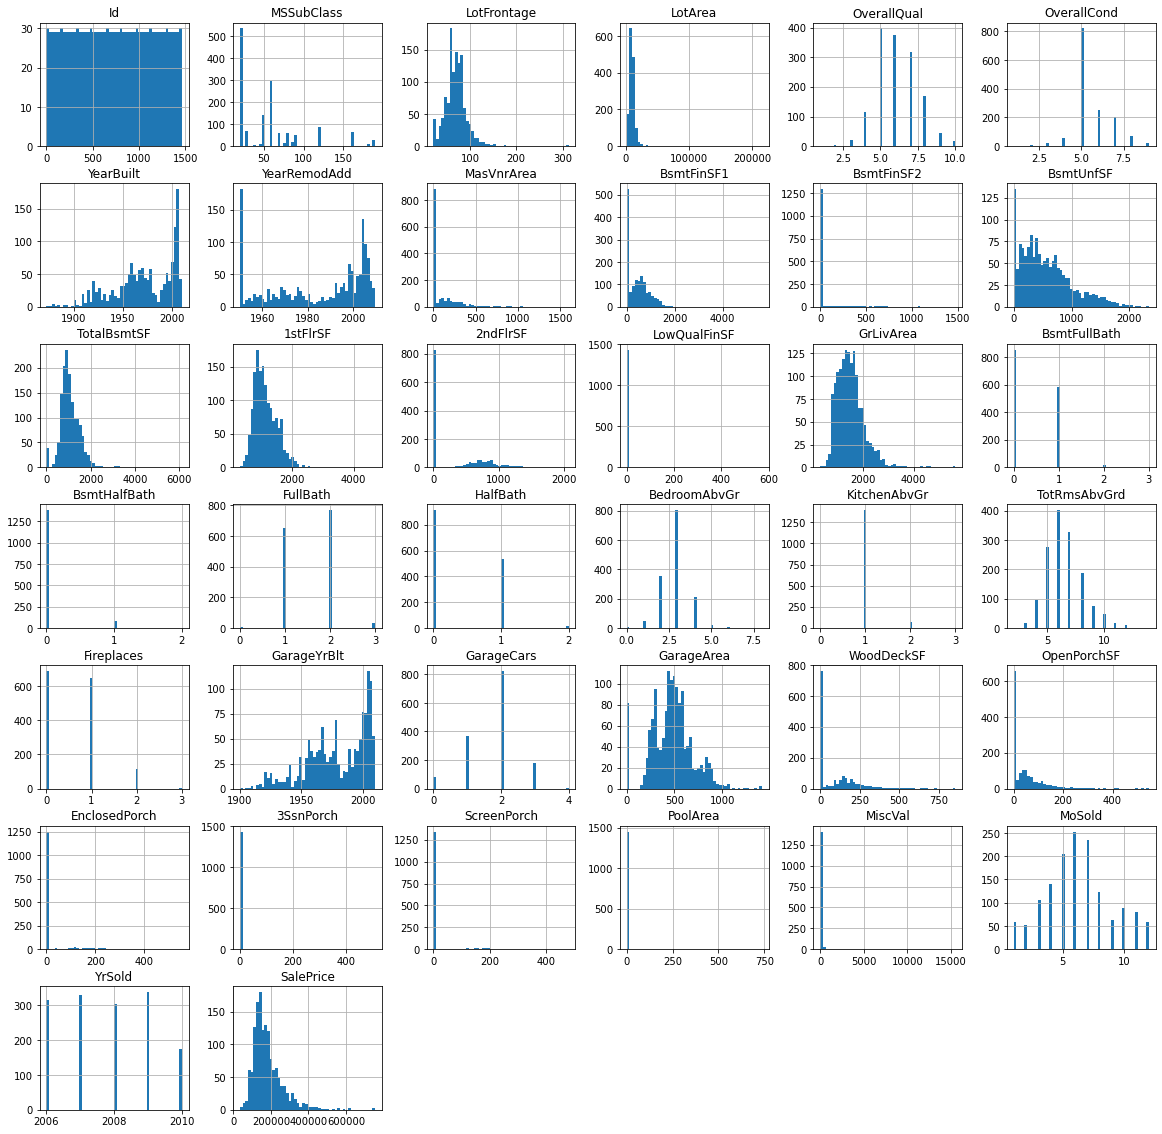

In [9]:
#Distribució de les dades
%matplotlib inline
train.hist(bins=50, figsize=(20,20))
plt.show()

In [10]:
#Observem les variables amb més influència en el preu final
coefficient_corr = train.corr()
print(coefficient_corr["SalePrice"].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

<AxesSubplot:>

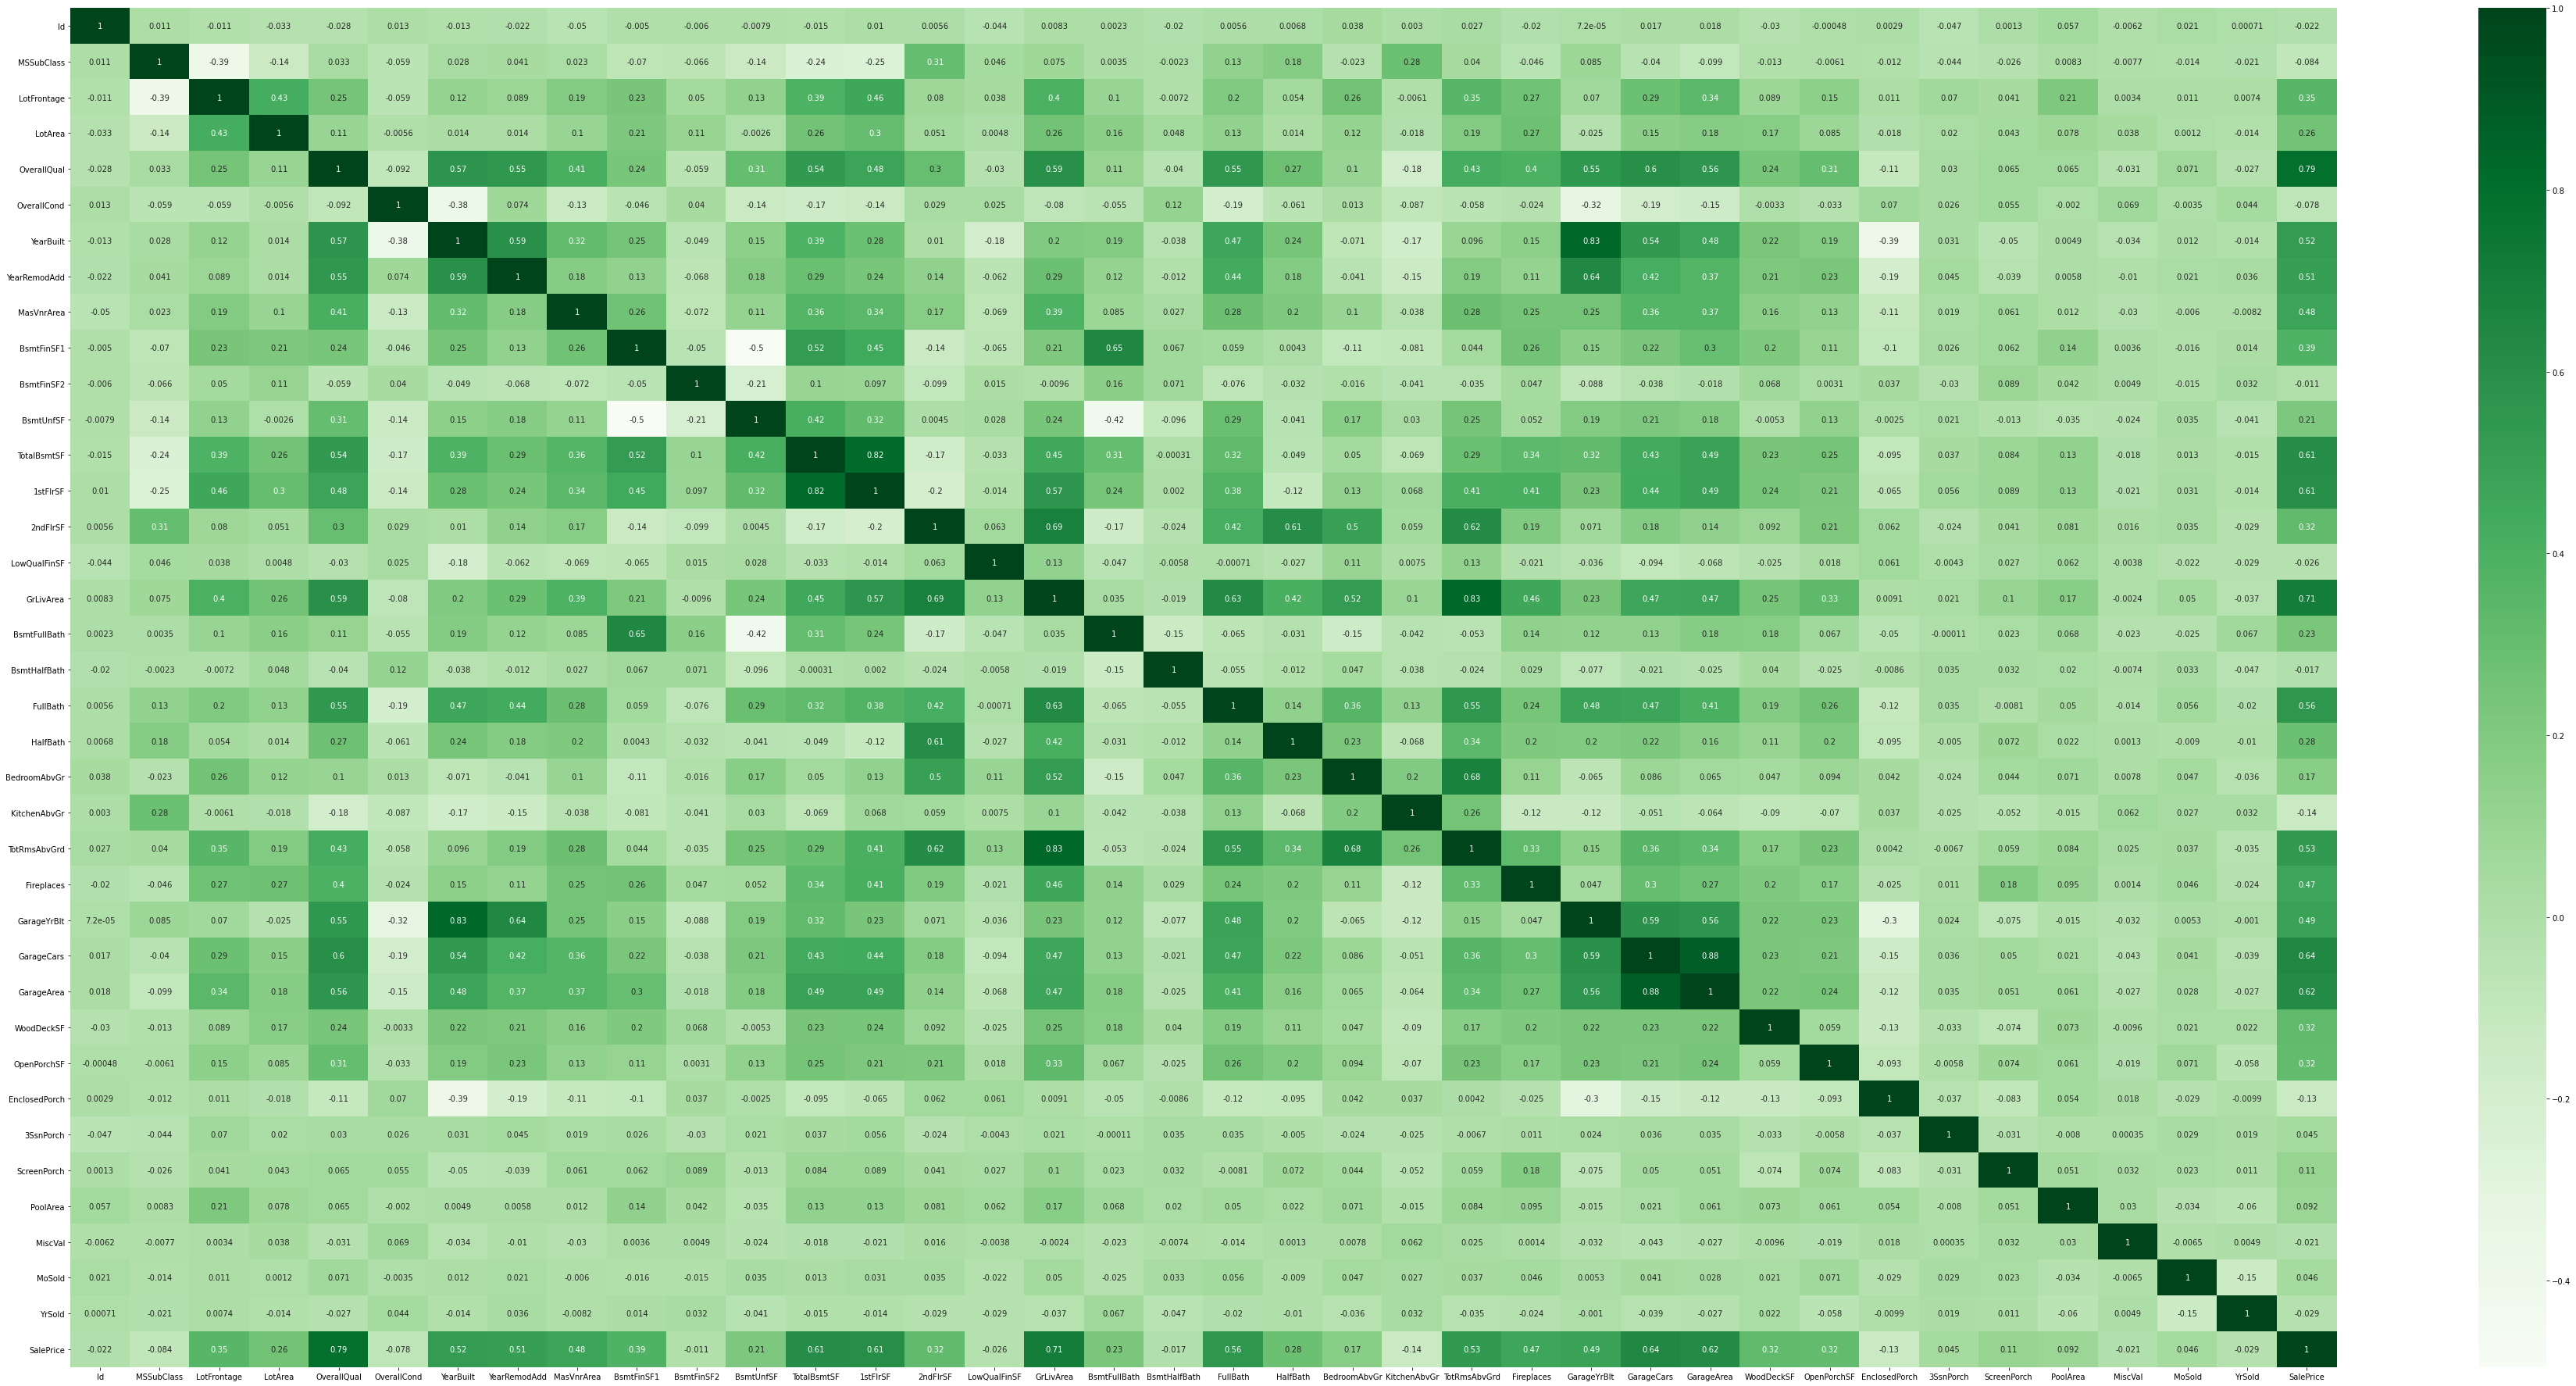

In [11]:
plt.figure(figsize=(65, 32))
sns.heatmap(coefficient_corr, annot=True, cmap="Greens")

## 3. Neteja de les dades

### 3.1 Valors nuls

In [12]:
#Fem un mix dels dos datasets
data = pd.concat([train.assign(ind="train"), submission.assign(ind="submission")])
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,ind
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,train


In [13]:
#Eliminem els NaNs que són erronis
fake_nans = ["Alley", "Fence", "MiscFeature", "FireplaceQu","BsmtFinType2", "BsmtFinType1", "BsmtExposure", "BsmtCond", "BsmtQual", "GarageFinish", "GarageCond", "PoolQC"]

for element in fake_nans:
    data[element].fillna("No", inplace=True)

In [14]:
#Omplim amb la mitja i moda aquells atributs que tenen valors NaN
fill_mode = ["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "KitchenQual", "Functional", "GarageType", "GarageQual","MasVnrType", "Electrical", "SaleType", "GarageYrBlt"]

fill_mean = ["GarageCars", "GarageArea", "TotalBsmtSF", "LotFrontage", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "BsmtFullBath", "BsmtHalfBath"]

for element in fill_mode:
    data[element].fillna(data[element].mode()[0], inplace=True)
for element in fill_mean:
    data[element].fillna(data[element].mean(), inplace=True)
data = data.round(5)

In [15]:
#Comprovem que no queden NaNs
data.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
Street              0
Alley               0
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          0
MasVnrArea          0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual            0
BsmtCond            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinSF1          0
BsmtFinType2        0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFin

### 3.2 Gestionar dades categòriques

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          2919 non-null   object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2919 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [17]:
#Utilitzem la funció .map per canviar el text a numeros mantenint l'ordre gradual
semi = {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3, "Po": 2, "No" : 0}
bsmnt1 = {"Gd" : 7, "Av" : 5, "Mn" : 2, "No" : 0}
bsmnt2 = {"GLQ" : 9, "ALQ" : 7, "BLQ" : 5, "Rec" : 3, "LwQ" : 2, "No" : 0, "Unf" : 0}

data["BsmtExposure"] = data["BsmtExposure"].map(bsmnt1)
data["BsmtFinType1"] = data["BsmtFinType1"].map(bsmnt2)
data["BsmtFinType2"] = data["BsmtFinType2"].map(bsmnt2)
data["CentralAir"] = data["CentralAir"].map({"N" : 0, "Y" : 1})

dades_qualificatives = ["ExterQual", "BsmtQual", "PoolQC", "ExterCond", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond"]

for element in dades_qualificatives:
    data[element] = data[element].map(semi)


In [18]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,ind
0,1,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,7,5,PConc,7,5,0,9,706.0,0,0.0,150.0,856.0,GasA,9,1,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,7,8,Typ,0,0,Attchd,2003.0,RFn,2.0,548.0,5,5,Y,0,61,0,0,0,0,0,No,No,0,2,2008,WD,Normal,208500.0,train
1,2,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,5,5,CBlock,7,5,7,7,978.0,0,0.0,284.0,1262.0,GasA,9,1,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,5,6,Typ,1,5,Attchd,1976.0,RFn,2.0,460.0,5,5,Y,298,0,0,0,0,0,0,No,No,0,5,2007,WD,Normal,181500.0,train
2,3,60,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,7,5,PConc,7,5,2,9,486.0,0,0.0,434.0,920.0,GasA,9,1,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,7,6,Typ,1,5,Attchd,2001.0,RFn,2.0,608.0,5,5,Y,0,42,0,0,0,0,0,No,No,0,9,2008,WD,Normal,223500.0,train
3,4,70,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,5,5,BrkTil,5,7,0,7,216.0,0,0.0,540.0,756.0,GasA,7,1,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,7,7,Typ,1,7,Detchd,1998.0,Unf,3.0,642.0,5,5,Y,0,35,272,0,0,0,0,No,No,0,2,2006,WD,Abnorml,140000.0,train
4,5,60,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,7,5,PConc,7,5,5,9,655.0,0,0.0,490.0,1145.0,GasA,9,1,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,7,9,Typ,1,5,Attchd,2000.0,RFn,3.0,836.0,5,5,Y,192,84,0,0,0,0,0,No,No,0,12,2008,WD,Normal,250000.0,train


In [19]:
data.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
Street              0
Alley               0
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          0
MasVnrArea          0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual            0
BsmtCond            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinSF1          0
BsmtFinType2        0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFin

### 3.3 Columnes amb baixa correlació

In [20]:
#Creem un dataset de atributs numèrics i eliminem les columnes amb una correlació menor al 50%
df = data.select_dtypes(include=np.number)
to_drop = []

threshold = 0.5
for feature in [c for c in df.columns if c != 'SalePrice']:
    if abs(df[feature].corr(df['SalePrice'])) < threshold:
        to_drop.append(feature)
print(to_drop)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'HeatingQC', 'CentralAir', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageYrBlt', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold']


In [21]:
for col in to_drop:
    data.drop(col, axis=1, inplace=True)

In [22]:
coefficient_corr = data.corr()
print(coefficient_corr["SalePrice"].sort_values(ascending=False))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.604816
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
FireplaceQu     0.522173
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


In [23]:
data

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,TotalBsmtSF,Heating,Electrical,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Functional,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition,SalePrice,ind
0,RL,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,7,PConc,7,856.0,GasA,SBrkr,856,1710,2,7,8,Typ,0,Attchd,RFn,2.0,548.0,Y,No,No,WD,Normal,208500.0,train
1,RL,Pave,No,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,5,CBlock,7,1262.0,GasA,SBrkr,1262,1262,2,5,6,Typ,5,Attchd,RFn,2.0,460.0,Y,No,No,WD,Normal,181500.0,train
2,RL,Pave,No,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,7,PConc,7,920.0,GasA,SBrkr,920,1786,2,7,6,Typ,5,Attchd,RFn,2.0,608.0,Y,No,No,WD,Normal,223500.0,train
3,RL,Pave,No,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,5,BrkTil,5,756.0,GasA,SBrkr,961,1717,1,7,7,Typ,7,Detchd,Unf,3.0,642.0,Y,No,No,WD,Abnorml,140000.0,train
4,RL,Pave,No,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,7,PConc,7,1145.0,GasA,SBrkr,1145,2198,2,7,9,Typ,5,Attchd,RFn,3.0,836.0,Y,No,No,WD,Normal,250000.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,5,CBlock,5,546.0,GasA,SBrkr,546,1092,1,5,5,Typ,0,Attchd,No,0.0,0.0,Y,No,No,WD,Normal,NaN,submission
1455,RM,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,5,CBlock,5,546.0,GasA,SBrkr,546,1092,1,5,6,Typ,0,CarPort,Unf,1.0,286.0,Y,No,No,WD,Abnorml,NaN,submission
1456,RL,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,5,CBlock,5,1224.0,GasA,SBrkr,1224,1224,1,5,7,Typ,5,Detchd,Unf,2.0,576.0,Y,No,No,WD,Abnorml,NaN,submission
1457,RL,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,5,PConc,7,912.0,GasA,SBrkr,970,970,1,5,6,Typ,0,Attchd,No,0.0,0.0,Y,MnPrv,Shed,WD,Normal,NaN,submission


## 4. Entrenament del model


In [24]:
#Separem els dos datasets
train = data[data["ind"] == "train"]
submission = data[data["ind"] == "submission"]

#Separem la variable target i les columnes que utilitzem per entrentar
#Utilitzem el Standard Scaler perquè tots els models funcionin correctament
sc = StandardScaler()

y = train[["SalePrice"]].values.ravel()
X = train[["OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars", "GarageArea", "TotalBsmtSF","BsmtQual", "1stFlrSF", "FullBath","TotRmsAbvGrd", "TotRmsAbvGrd", "YearBuilt", "FireplaceQu", "YearRemodAdd" ]]
x = sc.fit_transform(X)

#Fem una llista dels models i els entrenem un a un utilitzant la cross validation 
models = []
names = []
scores = []

models.append(("LinearRegression", LinearRegression()))
models.append(("Lasso", Lasso(alpha=0.1)))   
models.append(("Ridge", Ridge(alpha=20)))
models.append(("DecisionTree", DecisionTreeRegressor()))
models.append(("RandomForest", RandomForestRegressor()))
models.append(("BayesianRidge", BayesianRidge()))
models.append(("SupportVectorRegressor", SVR()))
models.append(("GBR", GradientBoostingRegressor()))


for name, model in models:
    names.append(name)
    score = -cross_val_score(model,x, y, cv=10, scoring="neg_mean_squared_error").mean()
    scores.append(score)
    print(f"{name} : {score}")

LinearRegression : 1404417609.2700448
Lasso : 1404415449.7037919
Ridge : 1396983411.1554441
DecisionTree : 1743798715.7804794
RandomForest : 982181658.3290884
BayesianRidge : 1399909415.7350786
SupportVectorRegressor : 6618398914.018568
GBR : 846839824.0306859


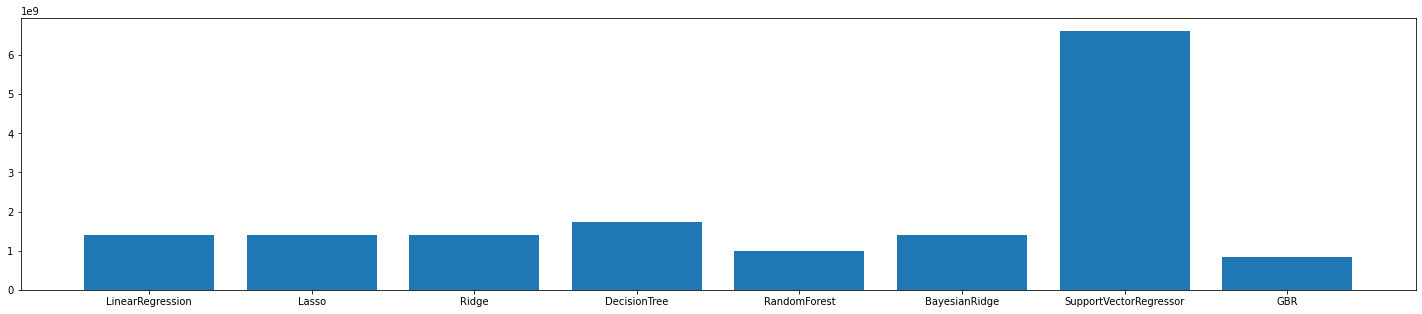

In [25]:
#Comparem els models
plt.rcParams['figure.figsize'] = [25, 5]
plt.bar(names,scores)
plt.show()

## 5. Hyperparameter Tuning


In [34]:
#Creem el test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#Realitzem diferents entrenaments i trobem els hyperparametres que donen menys error
test1 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

tuned_model = GridSearchCV(GradientBoostingRegressor(), test1, cv=3, scoring="r2")

tuned_model.fit(X_train, y_train)
tuned_model.best_params_, tuned_model.best_score_

({'learning_rate': 0.05, 'n_estimators': 100}, 0.8178226742187817)

In [27]:
test2 = {'max_depth':[2,3,4,5,6,7], 'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9] }

tuned_model = GridSearchCV(GradientBoostingRegressor(), test2, cv=4, scoring="r2")

tuned_model.fit(X_train, y_train)
tuned_model.best_params_, tuned_model.best_score_


({'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 60},
 0.8324623652799177)

In [35]:
test3 = {'max_features':[7, 8, 9, 10]}

tuned_model = GridSearchCV(GradientBoostingRegressor(), test3, cv=4, scoring="r2")

tuned_model.fit(X_train, y_train)
tuned_model.best_params_, tuned_model.best_score_

({'max_features': 9}, 0.832958427175101)

0.89148368523433


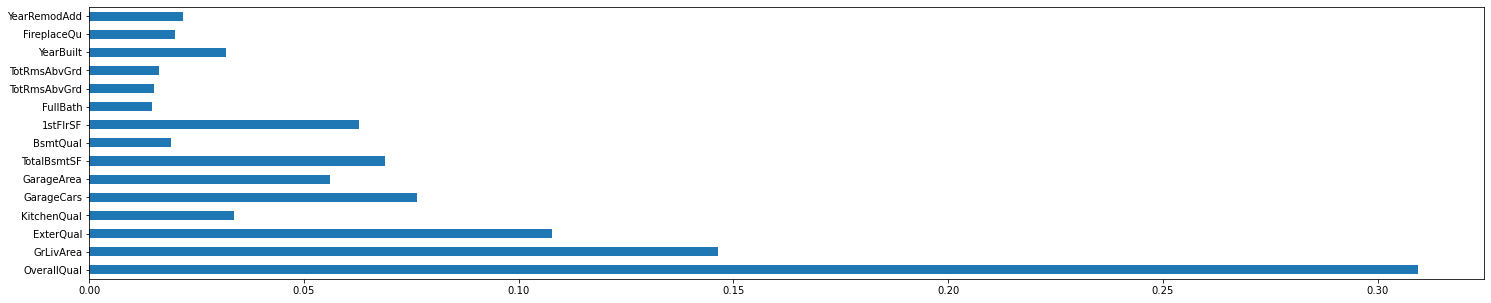

In [29]:
#Entrenem el model guanyador amb els hyperparametres més adequats

model = GradientBoostingRegressor(learning_rate=0.005, n_estimators=1750, max_depth=6, min_samples_leaf=1, min_samples_split=10, max_features=7)
model.fit(X_train,y_train)

#Visualitzem les columnes més importants
pd.Series(model.feature_importances_, index=X.columns).plot(kind='barh') 
score = model.score(X_test, y_test)
print(score)

## 6. Deploy


In [30]:
#Guardem el model
joblib.dump(model, "GradientBoostingRegressor.pkl")

['GradientBoostingRegressor.pkl']

In [31]:
sol_df = load_data(submission_set, path)
id_sol = sol_df["Id"]

x_submission = submission[["OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars", "GarageArea", "TotalBsmtSF","BsmtQual", "1stFlrSF", "FullBath","TotRmsAbvGrd", "TotRmsAbvGrd", "YearBuilt", "FireplaceQu", "YearRemodAdd" ]]


predictions = model.predict(x_submission)


solution = pd.DataFrame({"id":id_sol, "SalePrice": predictions})
solution.to_csv("submission.csv", index = False)

In [32]:
solution

,id,SalePrice
0,1461,230611.120848
1,1462,230611.120848
2,1463,224195.757917
3,1464,224195.757917
4,1465,238995.339163
...,...,...
1454,2915,245520.396500
1455,2916,230611.120848
1456,2917,216490.349691
1457,2918,245520.396500
